In [2]:
import random
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

seed = 42
np.random.seed(seed)
random.seed(seed)


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt', 'random', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Пример переобучения

Подготовим данные для демонстрации переобучения на них. Сгенерируем тренировочную и тестовую выборку с помощью линейной функции с нормальным шумом. 

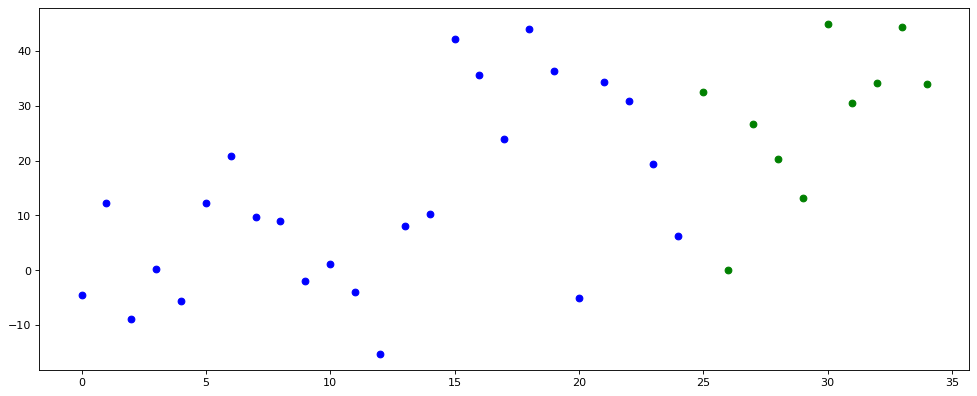

In [17]:
plt.figure(figsize=(15, 6), dpi=80)

# параметры выборки - размер и дисперсия шума
TRAIN_SET = 25
TEST_SET = 10
VARIANCE = 2.5

#генерация тренировочной выборки
x_train = np.array([i for i in range(TRAIN_SET)])
y_train = np.array([(x + 5 * np.random.normal(0,VARIANCE)) for x in x_train])

#генерация тестовой выборки
x_test = np.array([i for i in range(TRAIN_SET,TRAIN_SET + TEST_SET)])
y_test = np.array([(x + 5 * np.random.normal(0,VARIANCE)) for x in x_test])

plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

In [9]:
def poly_experiment_train(X_train, Y_train, nb_degree, model):
    """
    функция обучения для полиномиальной регрессии
    """
    # преобразование независимой переменной в количество признаков равному степени полинома
    polynomial_features = PolynomialFeatures(degree = nb_degree)
    X_TRANSF = polynomial_features.fit_transform(X_train.reshape(-1,1))
    #обучение линейной регрессии
    model.fit(X_TRANSF, Y_train)
    #оценка на обучающей выборке
    Y_NEW = model.predict(X_TRANSF)
    rmse = mean_squared_error(Y_train, Y_NEW,  squared=False)
    return {"transformer": polynomial_features,
            "model": model,
            "prediction": Y_NEW,
            'error': rmse}

def poly_experiment_test(X_test, Y_test, transformer, model):
    """
    функция предсказания на тестовой выборке. На вход обученный преобразователь в полином(transformer)
    и модель с подобранными весами.
    """
    X_TRANSF = transformer.transform(X_test.reshape(-1,1))
    Y_NEW = model.predict(X_TRANSF)
    rmse = mean_squared_error(Y_test, Y_NEW, squared=False)
    return {"prediction": Y_NEW, 'error': rmse}

(-10.0, 54.86001259565257)

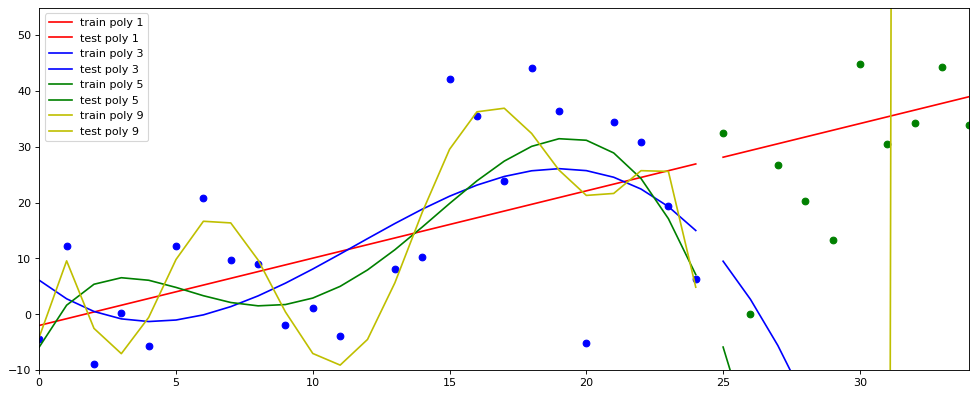

In [18]:
plt.figure(figsize=(15, 6), dpi=80)


models_coefs = []

test_mse_list = []

# рассмотрим полиномы соответсвующих степеней и определим цвета их графиков
degree_dict = {
    1: 'r',
    3: 'b',
    5: 'g',
    9: 'y',
}
for degree in degree_dict:
    # инициализируем модель
    model = LinearRegression()
    # предсказания на обучающей выборке
    train_pred = poly_experiment_train(x_train, y_train, degree, model)
    plt.plot(x_train, train_pred['prediction'], label = f'train poly {degree}', color=degree_dict[degree])
    
    #предсказания на тестовой выборке
    test_pred = poly_experiment_test(x_test, y_test, train_pred['transformer'], train_pred['model'])
    plt.plot(x_test, test_pred['prediction'], label = f'test poly {degree}', color=degree_dict[degree])
    
    test_mse_list.append(test_pred['error'])
    models_coefs.append(train_pred['model'].coef_)
    
    
# визуализация обучения
plt.legend(loc='best')

plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

plt.xlim(x_train[0], x_test[-1])
plt.ylim(np.min(x_train) - 10, np.max(y_test) + 10) 

In [11]:
# выведем ошибки полиномов на тестовой выборке
for key, error in zip(list(degree_dict.keys()), test_mse_list):
    print(f"poly {key} - {error}")

poly 1 - 14.792534768186504
poly 3 - 19.890818591768827
poly 5 - 106.1785334850657
poly 9 - 241.07327228124439


In [12]:
#посмотрим на коэфициенты обученных моделей
for key, coefs in zip(list(degree_dict.keys()), models_coefs):
    print(f"poly {key} :", coefs)
    print()

poly 1 : [0.         0.95400923]

poly 3 : [ 0.00000000e+00  9.71738593e-01  1.91486877e-03 -2.34228255e-05]

poly 5 : [ 0.00000000e+00  3.79806506e+00 -1.93092889e-01  5.09104169e-03
 -5.67034262e-05  2.24090446e-07]

poly 9 : [ 0.00000000e+00 -2.78520335e-04  1.80880931e-03  1.31835174e-02
 -1.01783831e-03  3.32732151e-05 -5.69049580e-07  5.31137284e-09
 -2.55534977e-11  4.93901794e-14]



#### Regularization

Воспользуемся регрессиями с регуляризацией - Lasso и Ridge. Посмотрим, как в обоих случаях влияет регуляризация на ошибку на тестовой выборке. 

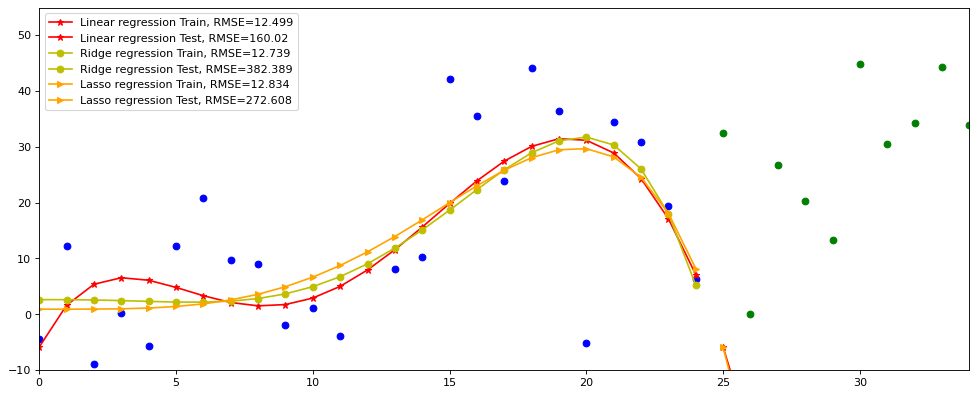

In [21]:
#linear regression
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

# для моделирования возьмем полином 4 степени
DEGREE = 5
# коэфициент регуляризации
ALPHA_SIZE = 2000

#обучим обычную линейную регрессию и версии с регуляризацией


lin_model = LinearRegression()
lin_train = poly_experiment_train(x_train, y_train, DEGREE, lin_model)
plt.plot(x_train, lin_train['prediction'], '*-', label = f"Linear regression Train, RMSE={round(lin_train['error'], 3)}", color='r')

lin_test = poly_experiment_test(x_test, y_test, lin_train['transformer'], lin_train['model'])
plt.plot(x_test, lin_test['prediction'], '*-', label = f"Linear regression Test, RMSE={round(lin_test['error'], 3)}", color='r')

ridge_model = Ridge(alpha=ALPHA_SIZE, random_state=seed)
ridge_train = poly_experiment_train(x_train, y_train, DEGREE, ridge_model)
plt.plot(x_train, ridge_train['prediction'], 'o-' ,label = f"Ridge regression Train, RMSE={round(ridge_train['error'], 3)}", color='y')

ridge_test = poly_experiment_test(x_test, y_test, ridge_train['transformer'], ridge_train['model'])
plt.plot(x_test, ridge_test['prediction'], 'o-', label = f"Ridge regression Test, RMSE={round(ridge_test['error'], 3)}", color='y')

lasso_model = Lasso(alpha=ALPHA_SIZE)
lasso_train = poly_experiment_train(x_train, y_train, DEGREE, lasso_model)
plt.plot(x_train, lasso_train['prediction'], '>-', label = f"Lasso regression Train, RMSE={round(lasso_train['error'], 3)}", color='orange')

lasso_test = poly_experiment_test(x_test, y_test, lasso_train['transformer'], lasso_train['model'])
plt.plot(x_test, lasso_test['prediction'], '>-' ,label = f"Lasso regression Test, RMSE={round(lasso_test['error'], 3)}", color='orange')

#посмотрим на графике, как меняется предсказание на тестовой выборке в зависимости от типа модели

plt.legend(loc='best')
plt.xlim(x_train[0], x_test[-1])
plt.ylim(np.min(x_train) - 10, np.max(y_test) + 10) 

plt.savefig('regularization_example.png')

/var/folders/hg/wyjbzhnn71d60tgsx5l8yt1c0000gn/T/ipykernel_62011/1085164522.py:20: RuntimeWarning: divide by zero encountered in log
  ax1.plot(np.log(ALPHA_LIST), coefs_list)
/var/folders/hg/wyjbzhnn71d60tgsx5l8yt1c0000gn/T/ipykernel_62011/1085164522.py:25: RuntimeWarning: divide by zero encountered in log
  ax2.plot(np.log(ALPHA_LIST), error_list)


Text(0.5, 1.0, 'Влияние регуляризации на ошибку модели')

<Figure size 1200x480 with 0 Axes>

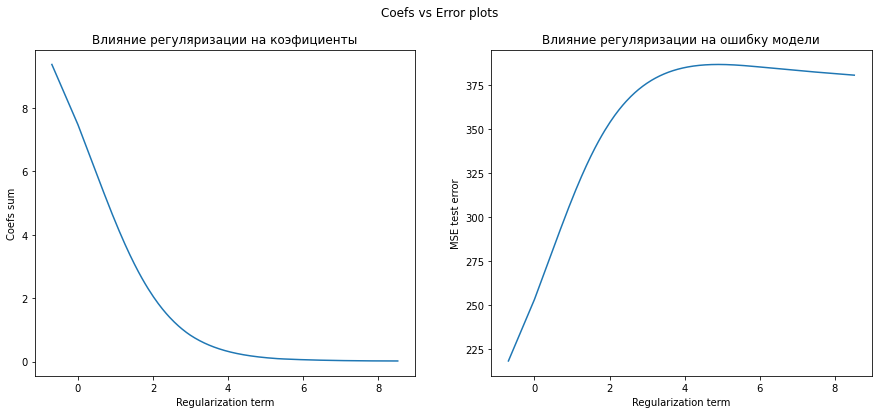

In [22]:
plt.figure(figsize=(15, 6), dpi=80)

ALPHA_LIST = np.linspace(0,5000, 10000)

coefs_list, error_list = [], []
#посмотрим на коэффициенты модели и ошибку на тестовой выборке при разных параметрах регуляризации
for alpha in ALPHA_LIST:
    ridge_model = Ridge(alpha=alpha, random_state=42)
    ridge_train = poly_experiment_train(x_train, y_train, DEGREE, ridge_model)
    ridge_test = poly_experiment_test(x_test, y_test, ridge_train['transformer'], ridge_train['model'])
    coefs_list.append(sum(np.abs(ridge_train['model'].coef_)))
    error_list.append(ridge_test['error'])

    
# построим графики зависимости
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle('Coefs vs Error plots')

ax1.plot(np.log(ALPHA_LIST), coefs_list)
ax1.set_xlabel('Regularization term')
ax1.set_ylabel('Coefs sum')
ax1.set_title('Влияние регуляризации на коэфициенты')

ax2.plot(np.log(ALPHA_LIST), error_list)
ax2.set_xlabel('Regularization term')
ax2.set_ylabel('MSE test error')
ax2.set_title('Влияние регуляризации на ошибку модели')

In [23]:
# найдем коэфициент регуляризации, при котором ошибка на тестовой выборке мнимальна
ALPHA_LIST[np.argmin(error_list)]

0.0

### Использование библиотеки OLS при регуляризации

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

In [25]:
# сделаем 
df = pd.read_csv("house_prices_train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [26]:
num_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                'MiscVal', 'MoSold', 'YrSold']

In [27]:
X_train, X_val, y_train, y_val = train_test_split(df[num_features], df['SalePrice'], test_size=0.25, random_state=42)
X_train.shape, X_val.shape

((1095, 32), (365, 32))

In [28]:
print(f"X_train: пустые значения: ")
total_na = np.sum(X_train.isna(), axis=0).reset_index()
total_na.columns = ['feature', 'count(missed)']
display(total_na[total_na['count(missed)'] > 0])

print(f"\nX_val: пустые значения: ")
total_na = np.sum(X_val.isna(), axis=0).reset_index()
total_na.columns = ['feature', 'count(missed)']
display(total_na[total_na['count(missed)'] > 0])

X_train: пустые значения: 


,feature,count(missed)
1,LotFrontage,200
7,MasVnrArea,4
20,GarageYrBlt,58



X_val: пустые значения: 


,feature,count(missed)
1,LotFrontage,59
7,MasVnrArea,4
20,GarageYrBlt,23


In [29]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

scaler = StandardScaler()
X_train = pd.DataFrame(
    data=scaler.fit_transform(X_train),
    index=y_train.index,
    columns=num_features)
X_train['const'] = 1

X_val = pd.DataFrame(
    data=scaler.transform(X_val),
    index=y_val.index,
    columns=num_features)
X_val['const'] = 1

### Отбор признаков с помощью L1 

In [16]:
model = sm.OLS(y_train, X_train)

alpha = 1
results = model.fit_regularized(alpha=alpha)

y_pred = results.predict(X_val)
n_features = [sum(results.params != 0)]
R_sqr = [r2_score(y_val, y_pred)]
alpha_list = []

while any(results.params != 0):
    
    results = model.fit_regularized(alpha=alpha)
    k = sum(results.params != 0)
    if k < n_features[-1]:
        n_features.append(k)
        y_pred = results.predict(X_val)
        R_sqr.append(r2_score(y_val, y_pred))
        print(k, end=' ')
    alpha_list.append(alpha)
    alpha += 100

29 27 25 22 21 20 19 18 17 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 

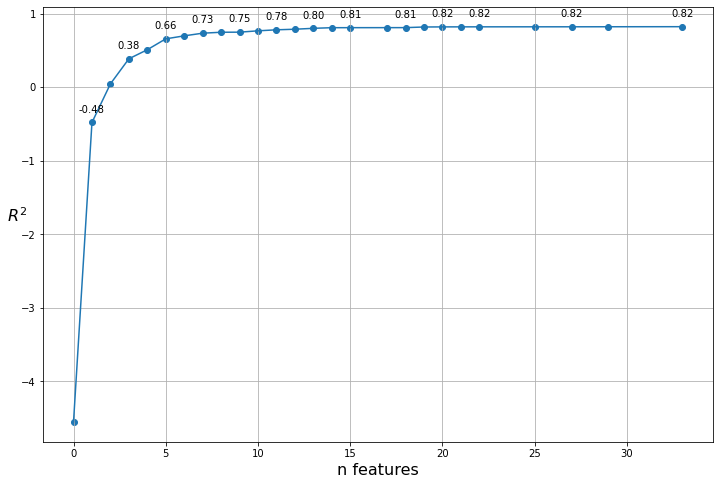

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(n_features, R_sqr)
plt.scatter(n_features, R_sqr)

for idx, (feats, r_squared) in enumerate(zip(n_features, R_sqr)):
    
    if idx % 2 == 0:
        label = "{:.2f}".format(r_squared)

        plt.annotate(label,
                     (feats,r_squared), 
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

plt.xlabel('n features', fontsize=16)
plt.ylabel('$R^2$', rotation=0, fontsize=16)
plt.grid()

### Обучение Ridge регрессии

In [18]:
model = sm.OLS(y_train, X_train)

ALPHA = np.linspace(1e-5, 5, 100)
RMSE = []
weights = []

for alpha in ALPHA:
    results = model.fit_regularized(L1_wt=0, alpha=alpha)
    y_pred = results.predict(X_val)
    RMSE.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    weights.append(np.mean(results.params**2)**0.5)
print(f"alpha_opt = {ALPHA[np.argmin(RMSE)]}")

alpha_opt = 1e-05


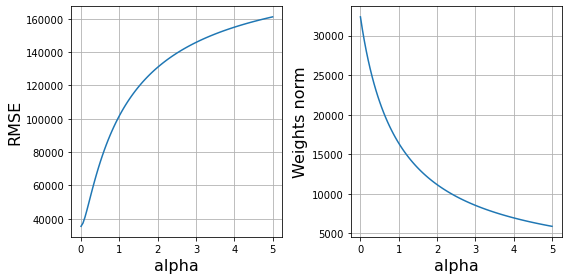

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].plot(ALPHA, RMSE)
axes[0].set_xlabel('alpha', fontsize=16)
axes[0].set_ylabel('RMSE', rotation=90, fontsize=16)
axes[0].grid()

axes[1].plot(ALPHA, weights)
axes[1].set_xlabel('alpha', fontsize=16)
axes[1].set_ylabel('Weights norm', rotation=90, fontsize=16)
axes[1].grid()

fig.tight_layout()

### Подбор оптимальной модели 

In [28]:
ALPHA = np.linspace(0, 40, 41)
L1_WT = np.linspace(0, 1, 11)
product_list = list(itertools.product(ALPHA, L1_WT))

alpha_list = []
L1_wt_list = []
RMSE = []
r2_score_list = []

for alpha, L1_wt in tqdm(product_list, total = len(product_list)):
    results = model.fit_regularized(L1_wt=L1_wt, alpha=alpha)
    y_pred = results.predict(X_val)
    alpha_list.append(alpha)
    L1_wt_list.append(L1_wt)
    RMSE.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    r2_score_list.append(r2_score(y_val, y_pred))

100%|██████████████████████████████████████████████████████████████████| 451/451 [00:41<00:00, 10.76it/s]


In [30]:
help(model.fit_regularized)

Help on method fit_regularized in module statsmodels.regression.linear_model:

fit_regularized(method='elastic_net', alpha=0.0, L1_wt=1.0, start_params=None, profile_scale=False, refit=False, **kwargs) method of statsmodels.regression.linear_model.OLS instance
    Return a regularized fit to a linear regression model.
    
    Parameters
    ----------
    method : str
        Either 'elastic_net' or 'sqrt_lasso'.
    alpha : scalar or array_like
        The penalty weight.  If a scalar, the same penalty weight
        applies to all variables in the model.  If a vector, it
        must have the same length as `params`, and contains a
        penalty weight for each coefficient.
    L1_wt : scalar
        The fraction of the penalty given to the L1 penalty term.
        Must be between 0 and 1 (inclusive).  If 0, the fit is a
        ridge fit, if 1 it is a lasso fit.
    start_params : array_like
        Starting values for ``params``.
    profile_scale : bool
        If True the pena

In [29]:
opt_id = np.argmin(RMSE)
print(f'RMSE = {RMSE[opt_id]}, R2 = {r2_score_list[opt_id]}, alpha = {alpha_list[opt_id]}, L1_wt = {L1_wt_list[opt_id]}')

RMSE = 35360.511414211745, R2 = 0.8215116909000527, alpha = 26.0, L1_wt = 1.0
